# Variational Quantum Image Classifier

This project is based on the IBM Quantum course https://learning.quantum.ibm.com/course/quantum-machine-learning/quantum-neural-networks

## Data Base

The initial stage involves the creation of an image dataset consisting of circles and crosses. This dataset will comprise a total of 60 images, subdivided into **40 training images** (20 circles and 20 crosses) and **20 testing images** (10 circles and 10 crosses). To construct this dataset, we developed the `symbols_maker.py` software, which facilitates the manual generation of freehand-drawn images on an 8x8 pixel grid. Subsequently, these images are automatically converted into binary vectors (`crosses.csv` and `circles.csv`), enabling their processing by the neural network. 


In [1]:
# Load and preprocess both CSVs
import pandas as pd
df_cross  = pd.read_csv('crosses.csv', header=None)
df_circle = pd.read_csv('circles.csv', header=None)

# Rename last column to 'Label' and map
df_cross.rename(columns={df_cross.columns[-1]: 'Label'}, inplace=True)
df_cross['Label']  = df_cross['Label'].map({1: 'Cross', 0: 'Circle'})
df_circle.rename(columns={df_circle.columns[-1]: 'Label'}, inplace=True)
df_circle['Label'] = df_circle['Label'].map({1: 'Cross', 0: 'Circle'})

# Reorder columns so 'Label' is first (avoid in‐place slice assignment)
cols_cross  = ['Label'] + [c for c in df_cross.columns  if c != 'Label']
cols_circle = ['Label'] + [c for c in df_circle.columns if c != 'Label']
df_cross  = df_cross[cols_cross]
df_circle = df_circle[cols_circle]

# Split each into first 20 rows (train) and last 10 rows (test)
train_cross, test_cross   = df_cross.iloc[:20], df_cross.iloc[20:]
train_circle, test_circle = df_circle.iloc[:20], df_circle.iloc[20:]

# Combine train/test sets
train_df = pd.concat([train_cross, train_circle], ignore_index=True)
test_df  = pd.concat([test_cross,  test_circle ], ignore_index=True)

# Extract features and labels
data_train   = train_df.drop('Label', axis=1).values
labels_train = train_df['Label'].values
data_test    = test_df .drop('Label', axis=1).values
labels_test  = test_df ['Label'].values

print(f"Train set: {len(data_train)} samples, {len(labels_train)} labels")
print(f"Test set:  {len(data_test)} samples, {len(labels_test)} labels")

Train set: 40 samples, 40 labels
Test set:  20 samples, 20 labels


## Dimensionality Reduction & Qubit Count

The following steps aim to reduce the 8×8 image data (64 features) to a smaller set of principal components and map them to qubits for quantum kernel classification.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

# Fit PCA to training data
pca = PCA(n_components=0.98)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Examine explained variance and component count
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Selected {n_components} components, explaining {explained_variance:.2%} variance.")

Selected 26 components, explaining 98.02% variance.


## Maping the qubits

In [22]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap

feature_map = ZFeatureMap(n_components, reps=2, parameter_prefix='a')

## Ansatz Construcction


5
2+ qubit depth: 3


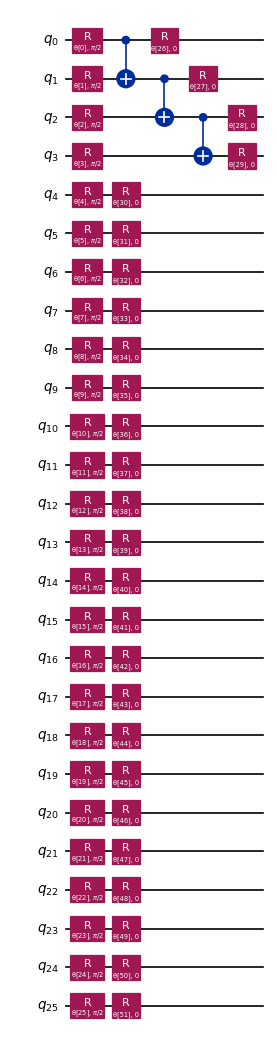

In [20]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

#Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(n_components)

#We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2*n_components)

#A first variational layer:
for i in range(n_components):
    qnn_circuit.ry(params[i],i)

#Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0,1],[1,2],[2,3]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0],qnn_cnot_list[i][1])

#The second variational layer:
for i in range(n_components):
    qnn_circuit.rx(params[n_components+i],i)

#Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}")

#Draw the circuit
qnn_circuit.decompose().draw("mpl", scale=0.6)